# Gesture Recognition project to detect 5 gestures

In [ ]:
#Importing liabraries
import numpy as np
import cv2
import imageio
import os
#from scipy.misc import imread, imresize
import datetime
import os
from skimage.transform import resize

We set the random seed so that the results don't vary drastically.

In [ ]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
#tf.set_random_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [1]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Reading sequence list from **Jarvislabs.ai**

In [ ]:
train_doc = np.random.permutation(open('datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('datasets/Project_data/val.csv').readlines())
batch_size = 32
size = (108, 108)

Checking 120x160 image after resize

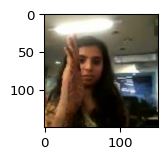

(150, 150, 3)

In [ ]:
import imgaug as ia
ima = imageio.imread('/content/gdrive/MyDrive/Colab Notebooks/Project_data/train/WIN_20180925_17_33_08_Pro_Left_Swipe_new/WIN_20180925_17_33_08_Pro_00011.png')
ima1 = resize(ima[:,20:140,:],size)
ia.imshow(ima1)
np.shape(ima1)


#### Generator
This is one of the most important part of the code. In the generator, image preprocessing with two different sizes done. Normalization done.

In [ ]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0, 3, 6, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 21, 23, 25, 27, 29]#create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size)
        remaining = len(t)%batch_size
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,18,108,108,3)) #creating empty tensor to feed 18 images from each sequence with size 108*108
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #resizing the images to standardize the input
                    if image.shape[1] == 160:
                        image = resize(image[:,20:140,:],size).astype(np.float32)
                    else:
                        image = resize(image, size).astype(np.float32)
                    #forming image tensor
                    batch_data[folder,idx,:,:,0] = image[:,:,0]*(1./255)#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1]*(1./255)#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]*(1./255)#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #yielding the batch_data and the batch_labels
     #Consideration of remaining sequences out of batch size
        if remaining != 0:
            batch_data = np.zeros((remaining,18,108,108,3)) #creating empty tensor for remaining images
            batch_labels = np.zeros((remaining,5)) # batch_labels is the one hot representation of the output
            for folder in range(remaining): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = resize(image[:,20:140,:],size).astype(np.float32)
                    else:
                        image = resize(image, size).astype(np.float32)
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0]*(1./255)#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1]*(1./255)#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]*(1./255)#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

Checking generator trial run

In [ ]:
a = generator('/content/gdrive/MyDrive/Colab Notebooks/Project_data/train', train_doc, 3)
print(next(a))

# Reading images from train & val data sets from **Jarvislabs.ai**. Summarizing number of sequences and feeding epochs

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = 'datasets/Project_data/train'#read from jarvis data set
val_path = 'datasets/Project_data/val'#read from jarvis data set
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 25
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 25


## 1st Model with 3D Convolution network **(not a final model)**

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here
model = Sequential()
model.add(Conv3D(32, (3,3,3), strides=(1,1,1), padding='same', input_shape=(18, 150, 150, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model.add(Dropout(0.25))

model.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model.add(Dropout(0.25))

model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

3D model compile & summary

In [ ]:
import keras.backend as K
# optimiser = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.optimizer.lr.assign(0.001)
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 18, 150, 150, 32)  2624      
                                                                 
 batch_normalization_12 (Bat  (None, 18, 150, 150, 32)  128      
 chNormalization)                                                
                                                                 
 activation_12 (Activation)  (None, 18, 150, 150, 32)  0         
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 9, 75, 75, 32)    0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 9, 75, 75, 64)     55360     
                                                                 
 batch_normalization_13 (Bat  (None, 9, 75, 75, 64)   

In [ ]:
print(K.eval(model.optimizer.lr))#Checking initial learning rate

0.01


Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = '2DCNN_108_bs32_sgd' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
steps_per_epoch

21

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_372/385748685.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  datasets/Project_data/train ; batch size = 32
Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 4.7327 - categorical_accuracy: 0.1931Source path =  datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to 3DCNN_150_bs32_adam_2023-01-1017_50_04.709817/model-00001-4.73270-0.19306-1.60964-0.16000.h5
21/21 [==============================] - 103s 5s/step - loss: 4.7327 - categorical_accuracy: 0.1931 - val_loss: 1.6096 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.6095 - categorical_accuracy: 0.1855
Epoch 00002: saving model to 3DCNN_150_bs32_adam_2023-01-1017_50_04.709817/model-00002-1.60951-0.18552-1.60964-0.15000.h5
21/21 [==============================] - 103s 5s/step - loss: 1.6095 - categorical_accuracy: 0.1855 - val_loss: 1.6096 - val_categorical_accuracy: 0.1500 - lr: 0.0010
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 1.6095 - categorical_a

## **Final Model** --> 2D CNN + RNN
Using transfer learning with VGG16 trained weights. Weights are trainable

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Dropout, Flatten, TimeDistributed
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.applications.vgg16 import VGG16
    
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(108,108,3))
x = base_model.output
x = Flatten()(x)
features = Dense(32, activation='relu')(x)
con2d_model = Model(inputs=base_model.input, outputs=features)
    
for layer in base_model.layers:
    layer.trainable = True
        
model_2dRnn = Sequential()
model_2dRnn.add(TimeDistributed(con2d_model, input_shape=(18,108,108,3)))
model_2dRnn.add(GRU(32, return_sequences=True))
model_2dRnn.add(GRU(16))
model_2dRnn.add(Dropout(0.5))
model_2dRnn.add(Dense(8, activation='relu'))
model_2dRnn.add(Dense(5, activation='softmax'))

In [ ]:
#Model defination, compilation. 
model_2dRnn.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['categorical_accuracy'])#Using Stochastic gradient descent and categorical crossentropy as loss
print (model_2dRnn.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_2 (TimeDis  (None, 18, 32)           14862176  
 tributed)                                                       
                                                                 
 gru_4 (GRU)                 (None, 18, 32)            6336      
                                                                 
 gru_5 (GRU)                 (None, 16)                2400      
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_7 (Dense)             (None, 8)                 136       
                                                                 
 dense_8 (Dense)             (None, 5)                 45        
                                                      

Calling generator function

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

Model fit

In [ ]:
model_2dRnn.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_403/662610721.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_2dRnn.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  datasets/Project_data/train ; batch size = 32
Epoch 1/25
21/21 [==============================] - ETA: 0s - loss: 1.6192 - categorical_accuracy: 0.2293Source path =  datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to 2DCNN_108_bs32_sgd_2023-01-1114_05_01.521686/model-00001-1.61918-0.22926-1.61516-0.22000.h5
21/21 [==============================] - 102s 5s/step - loss: 1.6192 - categorical_accuracy: 0.2293 - val_loss: 1.6152 - val_categorical_accuracy: 0.2200 - lr: 0.0100
Epoch 2/25
21/21 [==============================] - ETA: 0s - loss: 1.5852 - categorical_accuracy: 0.2851
Epoch 00002: saving model to 2DCNN_108_bs32_sgd_2023-01-1114_05_01.521686/model-00002-1.58515-0.28507-1.49706-0.35000.h5
21/21 [==============================] - 94s 5s/step - loss: 1.5852 - categorical_accuracy: 0.2851 - val_loss: 1.4971 - val_categorical_accuracy: 0.3500 - lr: 0.0100
Epoch 3/25
21/21 [==============================] - ETA: 0s - loss: 1.4965 - categorical_accu